In [39]:
# Imports
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F  # Make sure this import is here

In [2]:
# COCO Dataset for lat and lon only
class COCOGeolocationDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.geolocations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        input_size = num_classes * max_instances_per_class * 4  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        geolocations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            
            # Extract the expensive GPS data as the target output
            expensive_latitude = float(image_info['expensive_latitude'])
            expensive_longitude = float(image_info['expensive_longitude'])
            # Ensure that only latitude and longitude are included
            geolocation = [expensive_latitude, expensive_longitude]
            
            # Initialize the input vector with zeros
            input_vector = [0] * input_size

            # Find annotations corresponding to the image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    input_vector[start_index:start_index + 4] = bbox

            bounding_boxes.append(input_vector)
            geolocations.append(geolocation)  # Only latitude and longitude are appended
            image_files.append(image_info['file_name'])

        return bounding_boxes, geolocations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        geolocation = torch.tensor(self.geolocations[idx], dtype=torch.float32)  # This should now be of shape [2]
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, geolocation, image_path

In [3]:
# COCO dataset Compass Orientation only 
class COCOCompassDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.orientations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        input_size = num_classes * max_instances_per_class * 4  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        orientations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            
            # Extract the compass orientation as the target output
            compass_orientation = float(image_info['expensive_heading'])
            
            # Initialize the input vector with zeros
            input_vector = [0] * input_size

            # Find annotations corresponding to the image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    input_vector[start_index:start_index + 4] = bbox

            bounding_boxes.append(input_vector)
            orientations.append(compass_orientation)  # Only compass orientation is appended
            image_files.append(image_info['file_name'])

        return bounding_boxes, orientations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        orientation = torch.tensor([self.orientations[idx]], dtype=torch.float32)  # This should now be a single value in a tensor
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, orientation, image_path

In [85]:
# FFNN Arch.
class LatLonModel(nn.Module):
    def __init__(self):
        super(LatLonModel, self).__init__()
        self.fc1 = nn.Linear(72, 40)  # Single hidden layer with 40 neurons
        self.bn1 = nn.BatchNorm1d(40)  # Batch normalization
        self.fc2 = nn.Linear(40, 2)    # Output layer (latitude and longitude)
        self.dropout = nn.Dropout(p=0.3)  # DropoutRuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))  # Hidden layer with batch normalization and activation
        x = self.dropout(x)  # Apply dropout before the final output layer
        x = self.fc2(x)  # Output layer
        return x

# class CompassModel(nn.Module):
#     def __init__(self):
#         super(CompassModel, self).__init__()
#         self.fc1 = nn.Linear(72, 40)  # Single hidden layer with 40 neurons
#         self.bn1 = nn.BatchNorm1d(40)  # Batch normalization
#         self.fc2 = nn.Linear(40, 1)    # Output layer (compass orientation)
#         self.dropout = nn.Dropout(p=0.3)  # Dropout

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.fc1(x)))  # Hidden layer with batch normalization and activation
#         x = self.dropout(x)  # Apply dropout before the final output layer
#         x = self.fc2(x)  # Output layer
#         return x

import torch
import torch.nn as nn
import torch.nn.functional as F

class CompassModel(nn.Module):
    def __init__(self):
        super(CompassModel, self).__init__()
        
        # First hidden layer with batch normalization
        self.fc1 = nn.Linear(72, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.3
        
        # Second hidden layer with batch normalization
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.3
        
        # Output layer
        self.fc3 = nn.Linear(64, 1)  # Output layer (compass orientation)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        # Apply the first hidden layer with batch normalization, dropout, and activation function
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        # Apply the second hidden layer with batch normalization, dropout, and activation function
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Output layer
        x = self.fc3(x)
        return x
        
class CombinedModel(nn.Module):
    def __init__(self, lat_lon_model, compass_model):
        super(CombinedModel, self).__init__()
        self.lat_lon_model = lat_lon_model  # Pre-trained LatLonModel
        self.compass_model = compass_model  # Pre-trained CompassModel

    def forward(self, x):
        lat_lon_output = self.lat_lon_model(x)  # Predict lat and lon
        compass_output = self.compass_model(x)  # Predict compass orientation
        combined_output = torch.cat((lat_lon_output, compass_output), dim=1)  # Combine outputs
        return combined_output  # Output: [latitude, longitude, compass orientation]


In [37]:
# Load the COCO JSON data
coco_file_path = 'Test_4/Filtered_Lat_Lon_2BBox_Each_Class_Annotation.json'  
images_dir = 'Test_4/captured_images_test4' 

# Create the dataset for latitude and longitude
lat_lon_dataset = COCOGeolocationDataset(coco_file_path, images_dir)

print(f"Example bounding box for Lat/Lon: {lat_lon_dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(lat_lon_dataset))
test_size = len(lat_lon_dataset) - train_size
lat_lon_train_dataset, lat_lon_test_dataset = random_split(lat_lon_dataset, [train_size, test_size])

# Create dataloaders
lat_lon_train_dataloader = DataLoader(lat_lon_train_dataset, batch_size=10, shuffle=True)
lat_lon_test_dataloader = DataLoader(lat_lon_test_dataset, batch_size=10, shuffle=False)

# Create the dataset for compass orientation
compass_dataset = COCOCompassDataset(coco_file_path, images_dir)

print(f"Example bounding box for Compass: {compass_dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(compass_dataset))
test_size = len(compass_dataset) - train_size
compass_train_dataset, compass_test_dataset = random_split(compass_dataset, [train_size, test_size])

# Create dataloaders
compass_train_dataloader = DataLoader(compass_train_dataset, batch_size=10, shuffle=True)
compass_test_dataloader = DataLoader(compass_test_dataset, batch_size=10, shuffle=False)
# Load a single batch from the compass_train_dataloader
for inputs, targets, paths in compass_train_dataloader:
    # Assuming targets contain the compass orientation
    compass_orientation = targets[0].item()  # Get the first compass orientation in the batch
    print(f"Compass Orientation: {compass_orientation}")
    break  # Exit after the first batch


Example bounding box for Lat/Lon: torch.Size([72])
Example bounding box for Compass: torch.Size([72])
Compass Orientation: 248.7257843017578


In [70]:
# Initialize LatLonModel
lat_lon_model = LatLonModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lat_lon_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Training loop for LatLonModel
num_epochs = 100

for epoch in range(num_epochs):
    lat_lon_model.train()
    for inputs, targets, _ in lat_lon_train_dataloader:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass through the lat_lon_model
        outputs = lat_lon_model(inputs)
        
        # Ensure shapes match
        assert outputs.shape == targets.shape, "Shape mismatch between outputs and targets!"

        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Step the scheduler after each epoch
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Lat/Lon Loss: {loss.item():.8f}')
    
# Save the trained LatLonModel
lat_lon_model_save_path = "lat_lon_model_combined.pt"
torch.save(lat_lon_model.state_dict(), lat_lon_model_save_path)
print("Lat/Lon model training completed!")


Epoch [1/100], Lat/Lon Loss: 41.97323227
Epoch [2/100], Lat/Lon Loss: 42.93192673
Epoch [3/100], Lat/Lon Loss: 39.46464920
Epoch [4/100], Lat/Lon Loss: 42.73450851
Epoch [5/100], Lat/Lon Loss: 50.23820496
Epoch [6/100], Lat/Lon Loss: 9.50551224
Epoch [7/100], Lat/Lon Loss: 11.36945248
Epoch [8/100], Lat/Lon Loss: 21.85156822
Epoch [9/100], Lat/Lon Loss: 11.92941952
Epoch [10/100], Lat/Lon Loss: 13.05149841
Epoch [11/100], Lat/Lon Loss: 10.09632206
Epoch [12/100], Lat/Lon Loss: 8.17221451
Epoch [13/100], Lat/Lon Loss: 5.34348869
Epoch [14/100], Lat/Lon Loss: 8.14276123
Epoch [15/100], Lat/Lon Loss: 14.22530651
Epoch [16/100], Lat/Lon Loss: 11.39444447
Epoch [17/100], Lat/Lon Loss: 2.89405441
Epoch [18/100], Lat/Lon Loss: 2.38229823
Epoch [19/100], Lat/Lon Loss: 3.23739886
Epoch [20/100], Lat/Lon Loss: 3.01602101
Epoch [21/100], Lat/Lon Loss: 1.93301439
Epoch [22/100], Lat/Lon Loss: 1.04944444
Epoch [23/100], Lat/Lon Loss: 0.94423705
Epoch [24/100], Lat/Lon Loss: 1.59375668
Epoch [25/100

In [88]:
# Initialize CompassModel
compass_model = CompassModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(compass_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Training loop for CompassModel
num_epochs = 500

for epoch in range(num_epochs):
    compass_model.train()
    for inputs, targets, _ in compass_train_dataloader:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass through the compass_model
        outputs = compass_model(inputs)
        
        # Ensure shapes match
        assert outputs.shape == targets.shape, "Shape mismatch between outputs and targets!"

        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Step the scheduler after each epoch
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Compass Loss: {loss.item():.8f}')
    
# Save the trained CompassModel
compass_model_save_path = "compass_model_combined.pt"
torch.save(compass_model.state_dict(), compass_model_save_path)
print("Compass model training completed!")


Epoch [1/500], Compass Loss: 9207.13671875
Epoch [2/500], Compass Loss: 7451.47558594
Epoch [3/500], Compass Loss: 6390.19238281
Epoch [4/500], Compass Loss: 11224.26367188
Epoch [5/500], Compass Loss: 13839.86035156
Epoch [6/500], Compass Loss: 5540.86132812
Epoch [7/500], Compass Loss: 5301.40869141
Epoch [8/500], Compass Loss: 7532.61718750
Epoch [9/500], Compass Loss: 3474.73071289
Epoch [10/500], Compass Loss: 12705.41015625
Epoch [11/500], Compass Loss: 12876.54101562
Epoch [12/500], Compass Loss: 12260.09765625
Epoch [13/500], Compass Loss: 11562.45312500
Epoch [14/500], Compass Loss: 8051.97656250
Epoch [15/500], Compass Loss: 13323.42968750
Epoch [16/500], Compass Loss: 5066.35937500
Epoch [17/500], Compass Loss: 11067.04199219
Epoch [18/500], Compass Loss: 3883.58471680
Epoch [19/500], Compass Loss: 10506.48339844
Epoch [20/500], Compass Loss: 6149.53515625
Epoch [21/500], Compass Loss: 6370.64013672
Epoch [22/500], Compass Loss: 10971.15332031
Epoch [23/500], Compass Loss: 9

/tmp/ipykernel_39850/1662232097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lat_lon_model.load_state_dict(torch.load(lat_lon_model_save_path))
/tmp/ipykernel_39850/

Mean Squared Error on Test Set: 9379.28320312
Root Mean Squared Error (RMSE) on Test Set: 96.84669950
Actual Lat/Lon: (35.77130508, -78.67421722)
Predicted Lat/Lon: (35.77115250, -78.67448425)
Actual Compass: 0.00000000
Predicted Compass: 154.39317322


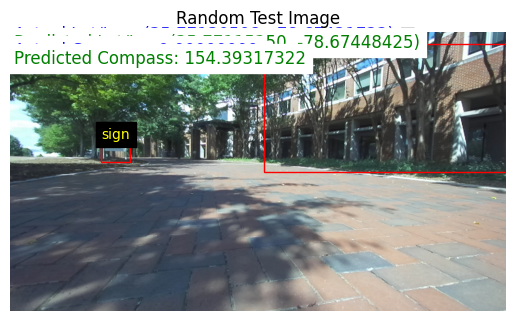

Actual Lat/Lon: (35.77069473, -78.67432404)
Predicted Lat/Lon: (35.77118683, -78.67444611)
Actual Compass: 0.00000000
Predicted Compass: 260.84240723


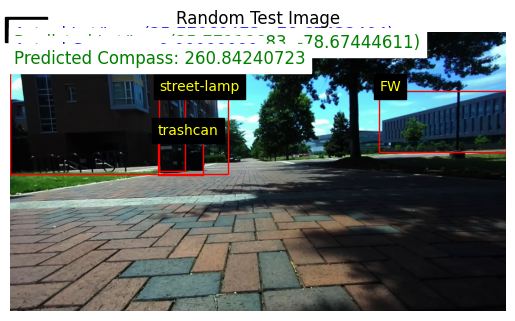

Actual Lat/Lon: (35.77069092, -78.67535400)
Predicted Lat/Lon: (35.77125549, -78.67440796)
Actual Compass: 0.00000000
Predicted Compass: 214.59848022


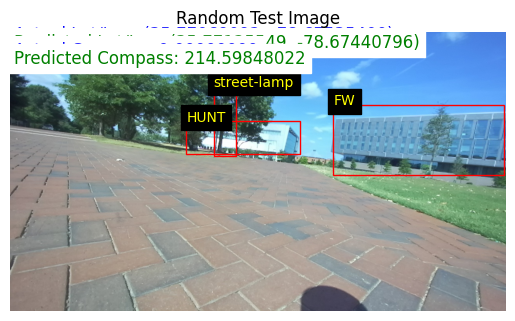

Actual Lat/Lon: (35.77016830, -78.67473602)
Predicted Lat/Lon: (35.77100372, -78.67461395)
Actual Compass: 0.00000000
Predicted Compass: 179.07496643


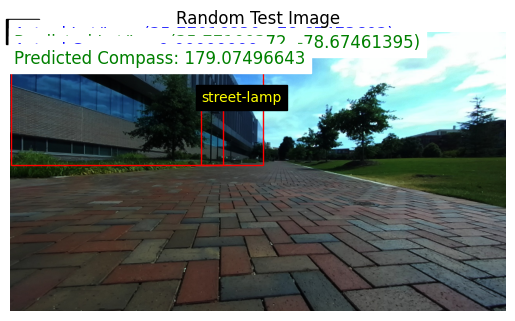

Actual Lat/Lon: (35.77136612, -78.67434692)
Predicted Lat/Lon: (35.77114487, -78.67447662)
Actual Compass: 0.00000000
Predicted Compass: 142.44854736


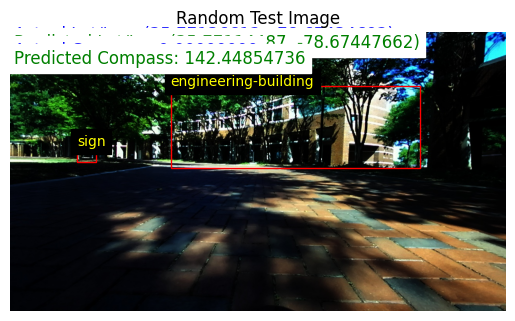

Actual Lat/Lon: (35.77099991, -78.67408752)
Predicted Lat/Lon: (35.77122879, -78.67441559)
Actual Compass: 0.00000000
Predicted Compass: 202.39509583


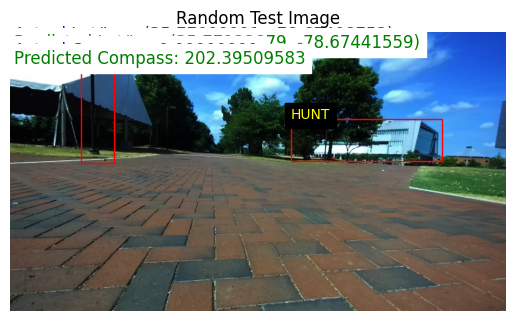

Actual Lat/Lon: (35.77112961, -78.67395020)
Predicted Lat/Lon: (35.77119446, -78.67443848)
Actual Compass: 0.00000000
Predicted Compass: 141.67779541


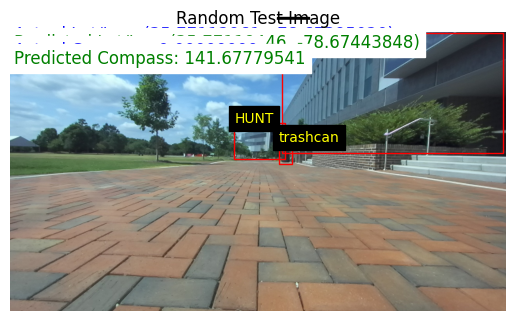

Actual Lat/Lon: (35.77105331, -78.67505646)
Predicted Lat/Lon: (35.77125931, -78.67437744)
Actual Compass: 0.00000000
Predicted Compass: 240.63740540


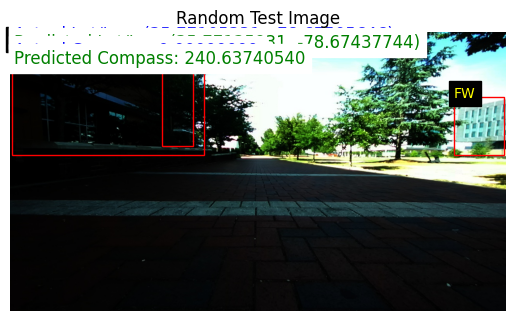

Actual Lat/Lon: (35.77047348, -78.67552948)
Predicted Lat/Lon: (35.77120209, -78.67446899)
Actual Compass: 0.00000000
Predicted Compass: 213.83886719


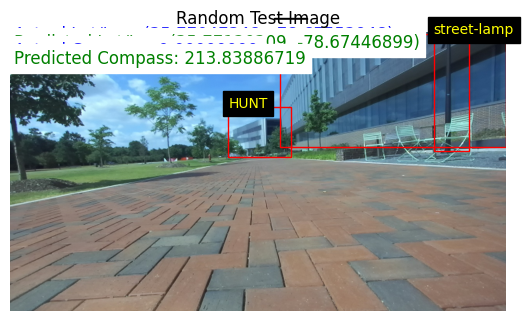

Actual Lat/Lon: (35.77112198, -78.67396545)
Predicted Lat/Lon: (35.77119827, -78.67442322)
Actual Compass: 0.00000000
Predicted Compass: 48.75508118


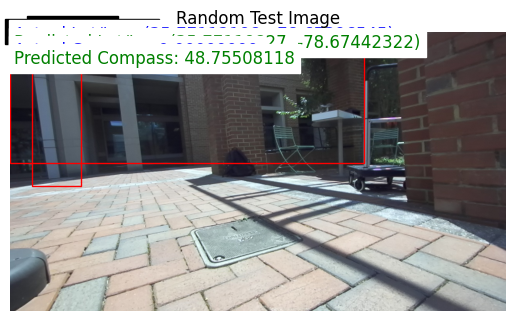

In [45]:
class CombinedModel(nn.Module):
    def __init__(self, lat_lon_model, compass_model):
        super(CombinedModel, self).__init__()
        self.lat_lon_model = lat_lon_model
        self.compass_model = compass_model

    def forward(self, x):
        lat_lon_output = self.lat_lon_model(x)
        compass_output = self.compass_model(x)
        combined_output = torch.cat((lat_lon_output, compass_output), dim=1)
        return combined_output
        
# Load pre-trained models
lat_lon_model = LatLonModel()
lat_lon_model.load_state_dict(torch.load(lat_lon_model_save_path))

compass_model = CompassModel()
compass_model.load_state_dict(torch.load(compass_model_save_path))

# Initialize the combined model
combined_model = CombinedModel(lat_lon_model, compass_model)

import random
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image

# Evaluate the combined model on the test set
combined_model.eval()
all_predictions = []
all_targets = []
image_paths = []

# Use lat_lon_test_dataloader for evaluation
with torch.no_grad():
    for inputs, targets, paths in lat_lon_test_dataloader:
        # Ensure targets include latitude, longitude, and compass
        if targets.shape[1] == 2:  # If only latitude and longitude are present
            compass_targets = torch.zeros((targets.shape[0], 1))  # Add a zero column for compass orientation
            targets = torch.cat((targets, compass_targets), dim=1)
        
        outputs = combined_model(inputs)
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.extend(paths)


# Combine all predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Mean Squared Error
mse = criterion(all_predictions, all_targets).item()
print(f'Mean Squared Error on Test Set: {mse:.8f}')

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.8f}')

# Function to visualize random test images with bounding boxes, geolocation labels, and compass orientation
def visualize_random_predictions(test_dataset, all_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_output = all_predictions[i].cpu().numpy()
        
        # Latitude and longitude
        predicted_lat_lon = predicted_output[:2]
        actual_lat_lon = geolocation[:2].numpy()
        
        # Compass orientation
        predicted_orientation = predicted_output[2]
        actual_orientation = geolocation[2].item() if len(geolocation) > 2 else 0  # Assuming geolocation has compass orientation, otherwise set it to 0

        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Assuming 9 classes, adjust if necessary
        max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display geolocations with clear labels (latitude, longitude, and compass orientation)
        plt.text(10, 20, f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})", color='green', fontsize=12, backgroundcolor='white')
        plt.text(10, 60, f"Actual Compass: {actual_orientation:.8f}", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 80, f"Predicted Compass: {predicted_orientation:.8f}", color='green', fontsize=12, backgroundcolor='white')
        
        print(f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})")
        print(f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})")
        print(f"Actual Compass: {actual_orientation:.8f}")
        print(f"Predicted Compass: {predicted_orientation:.8f}")
        
        plt.title('Random Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the test set
visualize_random_predictions(lat_lon_test_dataset, all_predictions, num_images=10)


Mean Squared Error on Compass Test Set: 7316.79638672
Root Mean Squared Error (RMSE) on Compass Test Set: 85.53827440
Actual Compass: 279.39822388
Predicted Compass: 75.38256073


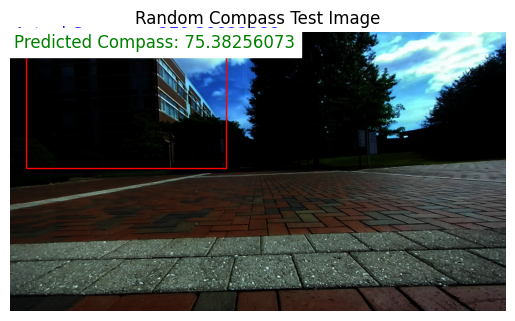

Actual Compass: 217.13531494
Predicted Compass: 211.69061279


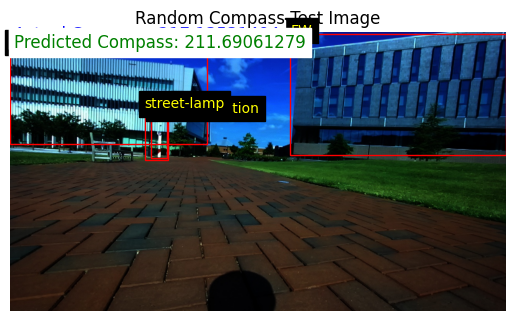

Actual Compass: 215.66200256
Predicted Compass: 210.11170959


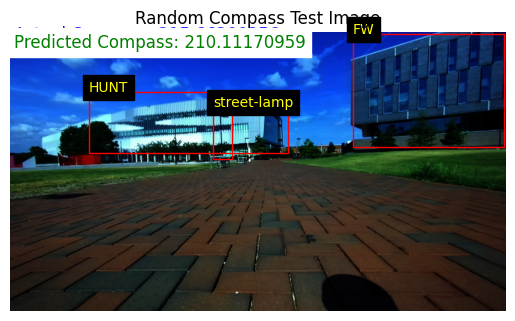

Actual Compass: 30.99238205
Predicted Compass: 89.42601776


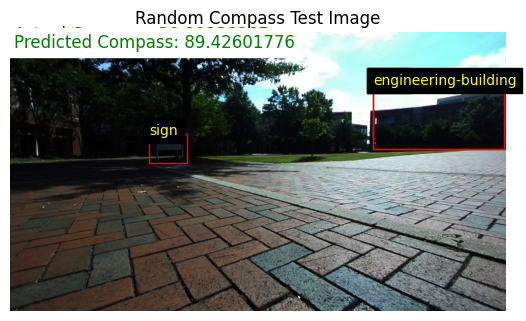

Actual Compass: 211.43742371
Predicted Compass: 112.36466980


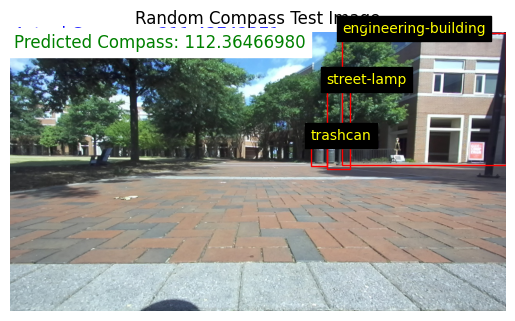

Actual Compass: 33.10834503
Predicted Compass: 115.54086304


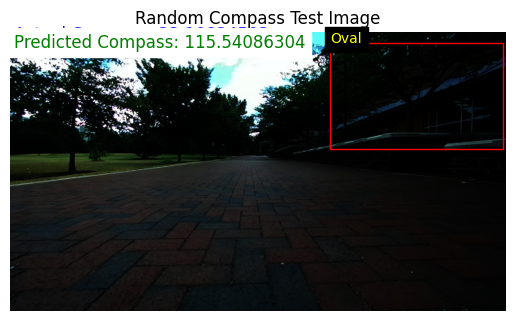

In [ ]:
# Result of compass model
import random
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image

# Evaluate the compass model on the test set
compass_model.eval()
compass_predictions = []
compass_targets = []
compass_image_paths = []

# Use compass_test_dataloader for evaluation
with torch.no_grad():
    for inputs, targets, paths in compass_test_dataloader:
        outputs = compass_model(inputs)
        compass_predictions.append(outputs)
        compass_targets.append(targets)
        compass_image_paths.extend(paths)

# Combine all predictions and targets for compass orientation
compass_predictions = torch.cat(compass_predictions, dim=0)
compass_targets = torch.cat(compass_targets, dim=0)

# Calculate Mean Squared Error for compass orientation
compass_mse = criterion(compass_predictions, compass_targets).item()
print(f'Mean Squared Error on Compass Test Set: {compass_mse:.8f}')

compass_rmse = math.sqrt(compass_mse)
print(f'Root Mean Squared Error (RMSE) on Compass Test Set: {compass_rmse:.8f}')

# Function to visualize random test images with compass orientation labels
def visualize_random_compass_predictions(test_dataset, compass_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_orientation = compass_predictions[i].cpu().numpy()[0]
        actual_orientation = geolocation[0].item()

        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Assuming 9 classes, adjust if necessary
        max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display compass orientation with clear labels
        plt.text(10, 20, f"Actual Compass: {actual_orientation:.8f}", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted Compass: {predicted_orientation:.8f}", color='green', fontsize=12, backgroundcolor='white')
        
        print(f"Actual Compass: {actual_orientation:.8f}")
        print(f"Predicted Compass: {predicted_orientation:.8f}")
        
        plt.title('Random Compass Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the compass test set
visualize_random_compass_predictions(compass_test_dataset, compass_predictions, num_images=10)
